# Molecular Mechanics

Quantum mechanics can in principle describes all the properties of atoms and molecules. However, in practice, quantum mechanical methods can only be applied to small systems (a few hundred atoms) because of their computational complexity. Quantum chemical models are therefore usually restricted to calculating the properties of molecules in their minimum energy structures or using a handful of possible conformations.

**Molecular mechanics** or **force field** methods sidestep the quantum mechanical nature of molecules altogether. Molecules are represented by atoms and bonds while electrons are no longer explicitly considered. The interactions between atoms are described classically using formulas containing empirical parameters. Such simplificantions makes these methods applicable for very large systems.

A major assumption in force field methods is that force field parameters are *transferable*. That is, they can be used across a broad range of molecular systems. For example, the C-H bond length is usually the same for all molecules in their equilibrium geometries, being between 1.06 and 1.10 Angstrom. The C-H stretching frequency is usually between 2900 and 3300 cm$^{-1}$ and therefore the C-H force constants are comparable across various systems.

## Atom Types
Force fields usually rely on the concept of **atom types**. An atom type is a label that denotes an atom with a given chemical environment. For example, a carbon atom that is sp$^3$ hybridized have a distinct chemical environment from a carbon atom in a carbonyl group (C=O). Thus, they can be assigned different atom types. Force fields differ in their definitions and assignment of atom types. The following table shows an example list of atom types from the AMBER force field force field:

![image](atom_types.png)

## The Force Field Energy
The force field energy is usually written as a sum of energy terms:
\begin{align}
    E_{\rm FF} = E_{\rm str} + E_{\rm bend} + E_{\rm tors} + E_{\rm vdw} + E_{\rm el}
\end{align}
where $E_{\rm str}$ is the energy required for *stretching* a bond, $E_{\rm bend}$ is the energy required for *bending* an angle, $E_{\rm tors}$ is the energy of *torsional* rotation, $E_{\rm vdw}$ is the *van der Waals* energy, and $E_{\rm el}$ is the *electrostatic* energy. $E_{\rm vdw}$ and $E_{\rm el}$ are the nonbonded energy terms. A visual representation of the various terms is shown below:

![image](force_field_terms_illustration.png)

### The Stretch Energy

Consider the following potential energy surface for a diatomic molecule:

![image](stretching.png)

We can arbitrarily set the minimum potential energy to zero. At the equilibrium or minimum energy bond length, we can expnd the potential energy using a Taylor series:
\begin{align}
    E(r) = E(r_{\rm eq}) + \left. \frac{dE}{dr} \right |_{r=r_{\rm eq}} (r-r_{\rm eq}) + 
          \left. \frac{1}{2!}\frac{d^2 E}{dr^2} \right |_{r=r_{\rm eq}} (r-r_{\rm eq})^2 +
          \left. \frac{1}{3!}\frac{d^3 E}{dr^3} \right |_{r=r_{\rm eq}} (r-r_{\rm eq})^3 + \cdots
\end{align}
The first term is set to zero arbitrarily, and the second term is zero because the first derivative is zero at the minimum. Thus, using the first nonzero term, we arrive at the Hooke's law expression:
\begin{align}
    E(r) = \frac{1}{2} k (r-r_{\rm eq})^2
\end{align}
where the force constant $k=\left. \frac{d^2 E}{dr^2} \right |_{r=r_{\rm eq}}$. This form is called a harmonic potential (depends on the square of the displacement). Farther away from the equilibrium bond length, the harmonic approximation becomes no longer appropriate. Additional terms in the Taylor expansion can be added. However, many force fields truncate the expansion to the harmonic potential. Note that trunctated Taylor expansions will not have the correct limiting behavior at long distances. While the Morse potential has the correct behavior:
\begin{align}
    E_{\rm Morse}(r) = D \left [1-e^{-\alpha (r-r_{\rm eq})}\right ]^2.
\end{align}
However, the Morse potential is not computationally efficient. It provides a small restoring force when the bond is stretched and therefore it can be slow during optimization. Most force fields study systems where the various degrees of freedom are close to the equilibrium value, and therefore the Taylor expansion is usually used. Note that some force fields absorb the factor $\frac{1}{2}$ in the force constant for the harmonic potential.

What is the meaning of the equilibrium bond length $r_{\rm eq}$ in this context? For a diatomic molecule, the equilibrium bond length is distance at which the potential energy is a minimum. However, for polyatomic molecules, other atoms will influence the bond length of a given pair of atoms, and therefore the minimum energy structure is unlikely to have the specified equilibrium bond length. However, most molecules will display limited deviation from the assigned equilibrium bond length.

Having specified the functional form for the stretching energy, what is needed is to determine the value of the force constant $k^{\rm AB}$ and the equilibirum bond length $r_{\rm eq}^{\rm AB}$ for all pairs of atom types.

Below is an example for the stretching of the F$_2$ molecule.

In [1]:
from openbabel import openbabel as ob
import numpy as np
import matplotlib.pyplot as plt
import nglview as nv
import ipywidgets as widgets
from IPython.display import display

conv = ob.OBConversion()
mol = ob.OBMol()
conv.SetInFormat("xyz")
xyz_string = """2

F 0 0 0
F 1 0 0"""
conv.ReadString(mol, xyz_string)
bond = mol.GetBond(0)

ff = ob.OBForceField.FindForceField("GAFF")
ff.Setup(mol)

lengths = np.arange(0.5, 1.75, 0.05)
views = [nv.NGLWidget() for i in range(len(lengths))]
energies = []
for i in range(len(lengths)):
    mol.GetBond(0).SetLength(lengths[i])
    views[i].add_structure(nv.OpenbabelStructure(mol))
    ff.SetCoordinates(mol)
    energies.append(ff.Energy())

def show(frame):
    plt.figure()
    plt.plot(lengths, energies)
    plt.yticks([], [])
    plt.xlabel("Length ($\\rm \\AA$)")
    plt.ylabel("Energy")
    plt.vlines(lengths[frame], np.min(energies), np.max(energies), color="k", ls='--')
    plt.show()
    views[frame].center()
    display(views[frame])

widgets.interact(show, frame=widgets.IntSlider(min=0, max=len(lengths)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='frame', max=24), Output()), _dom_classes=('widget-intera…

<function __main__.show(frame)>

## The Bending Energy
The energy associated with bending the angle $\theta$ between three bonded atoms can similarly be expressed using a harmonic potential:
\begin{align}
    E(\theta) = \frac{1}{2} k (\theta - \theta_{\rm eq})^2
\end{align}
where again $k$ is the force constant and $\theta_{\rm eq}$ is the equilibrium angle. Note that the harmonic potential fails to describe the barrier to linearity. For example, water molecule has an energy maximum in the linear form and therefore the energy derivative is equal to zero and the second derivative is negative. This cannot be enforced for harmonic potentials.

Again, we need to determine the value of the force constant $k^{\rm ABC}$ and the equilibirum angle $\theta_{\rm eq}^{\rm ABC}$ for all triples of atom types.

Below is an example for the bending of the H$_2$O molecule.

In [2]:
from openbabel import openbabel as ob
import numpy as np
import matplotlib.pyplot as plt
import nglview as nv
import ipywidgets as widgets
from IPython.display import display

conv = ob.OBConversion()
mol = ob.OBMol()
conv.SetInFormat("xyz")
xyz_string = """3

O  0.00000000   0.00000000     0.00000000
H  0.00000000   1.05000000     0.00000000
H  0.98994949  -0.35000000     0.00000000"""
conv.ReadString(mol, xyz_string)

m = ob.matrix3x3()
v = ob.vector3(0, 0, 1)
v3 = ob.vector3(mol.GetAtom(3).GetVector())


ff = ob.OBForceField.FindForceField("MMFF94")
ff.Setup(mol)

angles = np.arange(80, 130, 2)
views = [nv.NGLWidget() for i in range(len(angles))]
energies = []
for i in range(len(angles)):
    m.RotAboutAxisByAngle(v, angles[i]-109.471)
    v_current = ob.vector3(v3)
    v_current *= m
    mol.GetAtom(3).SetVector(v_current)
    views[i].add_structure(nv.OpenbabelStructure(mol))
    ff.SetCoordinates(mol)
    energies.append(ff.Energy())

def show(frame):
    plt.figure()
    plt.plot(angles, energies)
    plt.yticks([], [])
    plt.xlabel("Angle ($\\circ$)")
    plt.ylabel("Energy")
    plt.vlines(angles[frame], np.min(energies), np.max(energies), color="k", ls='--')
    plt.show()
    views[frame].center()
    display(views[frame])

widgets.interact(show, frame=widgets.IntSlider(min=0, max=len(angles)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='frame', max=24), Output()), _dom_classes=('widget-intera…

<function __main__.show(frame)>

## The Torsional Energy
The torsional angle between four consecutive atoms A, B, C, and D is the angle between the ABC plane and the BCD plane. The torsional angle is periodic and it is usually defined between 0 and 360$^\circ$ or between -180 and 180$^\circ$.

Because the torsional angle is periodic, the potential energy as a function of the torsional angle is also periodic.  Moreover, torsional energy barriers are often small and therefore large deviations from the minimum energy torsional angle are often possible. Therefore, a Taylor expansion of the form used for the stretching and bending energies is not suitable. Instead, the torsional energy is usually expanded in terms of a periodic Fourier series:
\begin{align}
    E_{\rm tors}(\omega) = \sum_{n=1} V_n {\rm cos}(n \omega).
\end{align}
The $n$ factor controls the periodicity of the torsional angle. For example, $n=1, 2, 3$ corresponds to periodicities of 360, 180, 120$^\circ$. The $V_n$ determines the energy barrier to the rotation. A negative $V_n$ value converts a minimum to a maximum.

To illustrate the potential energy shape, we plot below the energy function for $n=1, 2, 3$ and set $V_n=1$. 

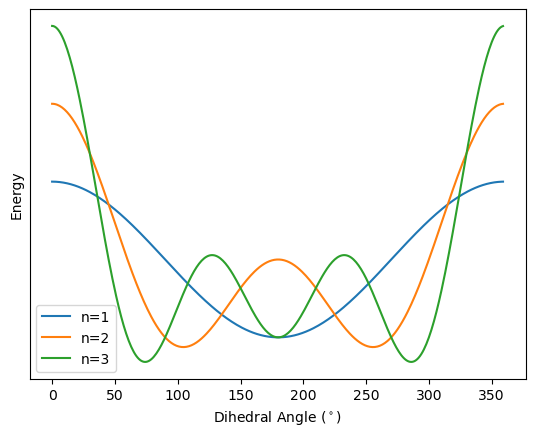

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def torsional_energy(omega, Vn):
    omega = np.array(omega) * np.pi / 180.0
    energy = np.zeros(omega.size) 
    for n in range(1, len(Vn) + 1):
        energy += Vn[n-1] * np.cos(n * omega)
        
    return energy

angles = np.arange(0, 360, 1)
Vn = []

plt.figure()

for n in range(1, 4):
    Vn.append(1)
    energy = torsional_energy(angles, Vn)

    plt.plot(angles, energy, label="n=%i" %n)

plt.legend()
plt.xlabel("Dihedral Angle ($^\\circ$)")
plt.ylabel("Energy")
plt.yticks([], [])
plt.show()

Force fields sometimes use a slightly different expression given by
\begin{align}
    E (\omega) = \frac{1}{2} \sum_n V_n [1 + (-1)^{n+1} {\rm cos}(n \omega + \psi_n)]
\end{align}
where $\psi_n$ is a phase factor. The $\frac{1}{2}$ is included so that the $V_n$ term is equal to the maximum value that a particular term can contribute to the energy. The sign factor $(-1)^{n+1}$ is included so that the value in bracket to zero at $\omega=180^\circ$ if $\psi=0$.

The symmetry of the molecule determines which values of $n$ are allowed in the expansion (or which $V_n$ terms are zero). For example, for ethane, there are three equivalent staggered configurations that are energy minima while there are three equivalent eclipsed configuration that are energy mixima. Therefore, only terms with $n=3, 6, 9, \cdots$ are allowed.

Below is an example for the torsional rotation of ethane.

In [4]:
from openbabel import openbabel as ob
import numpy as np
import matplotlib.pyplot as plt
import nglview as nv
import ipywidgets as widgets
from IPython.display import display

conv = ob.OBConversion()
mol = ob.OBMol()
conv.SetInFormat("xyz")
xyz_string = """8

C    0.00000000  0.00000000  0.00000000
C    1.53832585  0.07178854 -0.00000000
H    1.94916961 -0.93781901  0.00000000
H    1.87731148  0.60199800 -0.88998127
H    1.87731148  0.60199800  0.88998127
H   -0.41084377  1.00960755 -0.00000000
H   -0.33898564 -0.53020946 -0.88998127
H   -0.33898564 -0.53020946  0.88998127"""
conv.ReadString(mol, xyz_string)

ff = ob.OBForceField.FindForceField("MMFF94")

angles = np.arange(0, 360, 5)
views = [nv.NGLWidget() for i in range(len(angles))]
energies = []
for i in range(len(angles)):
    mol.SetTorsion(3, 2, 1, 6, angles[i]*np.pi/180.0)
    views[i].add_structure(nv.OpenbabelStructure(mol))
    ff.Setup(mol)
    energies.append(ff.Energy())

def show(frame):
    plt.figure()
    plt.plot(angles, energies)
    plt.yticks([], [])
    plt.xlabel("Dihedral Angle ($\\circ$)")
    plt.ylabel("Energy")
    plt.vlines(angles[frame], np.min(energies), np.max(energies), color="k", ls='--')
    plt.show()
    views[frame].center()
    display(views[frame])

widgets.interact(show, frame=widgets.IntSlider(min=0, max=len(angles)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='frame', max=71), Output()), _dom_classes=('widget-intera…

<function __main__.show(frame)>

## Out-of-Plane Bending and Improper Torsions
A special force field term is often needed to describe the energy associated with making the geometry of four atoms pyramidal. The figure below illustrates the pyramidal structure:

![image](out_of_plane_bending.png)

For a planar structure, $\angle_{\rm ABC} + \angle_{\rm ABD} + \angle_{\rm CBD} = 360^\circ$. Large pyramidalization can be achieved while the sum of the three angles remain close to 360$^\circ$. For example, if the bond distances are 1.5 Angstroms, moving the central atom by 0.2 Angstroms out of the plane ($\chi=7.7^\circ$) reduces the sum only to 354.8$^\circ$. Very large angle bending force constants would be needed if the ABC, ABD, and CBD bending potentials are used to describe pyramidalization energy. This would make the in-plane bending potential too stiff. Therefore, a special out-of-plane bending term is often added while the in-plane angle-bending is treated as described above. The out-of-plane bending potential is modeled as
\begin{align}
    E_{\rm oop}(\chi) = k \chi^2 \quad {\rm or} \quad E_{\rm oop}(d) = k d^2.
\end{align}

Instead of using the above out-of-plane bending potential, sometimes an *improper* torsional potential is defined in terms of the torsional angle ABCD (some of the atoms are nonbonded). The torsional energy can have a harmonic form ($(\omega - \omega_{\rm eq})^2$ or can be described by the above Fourier expansion with large $V_2$ constant. 

## The van der Waals Energy
van der Waals and electrostatic energy terms describe the interactions between nonbonded atoms. The van der Waals interaction consists of two terms: one slightly attractive at long distances, and one strongly repulsive at short distances. The attractive force is due to disperion interaction, which are typically thought of as instantaneous dipole-induced dipole interactions. This attractive force is what binds noble gas atoms at low temperatures. The leading term in the dispersion forces can theoretically be shown to have an $r^{-6}$ dependence. On the other hand, the repulsive force between two atoms arise because of the repulsion between electronic clouds as the atoms approach each other. This is a consequence of the Pauli exclusion principle.

van der Waals interactions are usually modeled using the **Lennard-Jones potential**:
\begin{align}
    E_{\rm LJ}(r) = 4 \epsilon \left[ \left (\frac{\sigma}{r} \right )^{12} - \left (\frac{\sigma}{r} \right )^{6} \right ]
\end{align}
where $\epsilon$ is the Lennard-Jones well-depth and $\sigma$ is the interatomic separation where the repulsive and attractive forces are equal.

Why is the $r^{-12}$ dependence chosen for the repulsive part? In fact, there is no theoretical justification but it used because it is computationally efficent. The $r^{-12}$ value can be obtained by multiplying the physically justified $r^{-6}$ term by itself. Furthermore, computing the distance between two atoms require taking the square root
\begin{align}
    r_{\rm AB} = \sqrt{(x_{\rm A} - x_{\rm B})^2 + (y_{\rm A} - y_{\rm B})^2 + (z_{\rm A} - z_{\rm B})^2}
\end{align}
Having *even* powers in the energy function allows one to avoid computing the square root. Additionally, more physically justifiable functional forms, such as the Morse potential, requires computing an exponential, which roughly takes five times the CPU time needed for simpler mathematical functions, such as addition and multiplication. Is this in fact needed? It turns out that computing the nonbonded terms is the most computationally expensive steps in force field calculations. This is because there are ${\sim N^2}$ number of possible atomic pairs in a system.

How are the $\sigma$ and $\epsilon$ parameters determined? These parameters depend on the atom types for the atom pairs A and B. Typically, $\sigma$ and $\epsilon$ values are assigned for each atom type, and the $\sigma$ and $\epsilon$ values for the atom pair is determined using a specific *combination rule*. This is usually the arithmetic mean for $\sigma$ and the geometric mean for $\epsilon$:
\begin{align}
    \sigma^{\rm AB} &= \frac{1}{2} ( \sigma_{\rm A} + \sigma_{\rm B}) \\
    \epsilon^{\rm AB} &= \sqrt{ \epsilon_{\rm A} \epsilon_{\rm B}}
\end{align}
However, other combination rules are also often used.

It should be noted that van der Waals interaction, and also electrostatic interactions discussed below, are usually set to zero for pairs of atoms involved in bonds or angles because the bonded terms account for their interaction. The nonbonded terms for atom pairs that share a dihedral angle (1-4 atoms) are scaled down by a fixed factor in some force fields.

Below we illustrate the dependence of the Lennard-Jones potential on $\epsilon$ and $\sigma$.

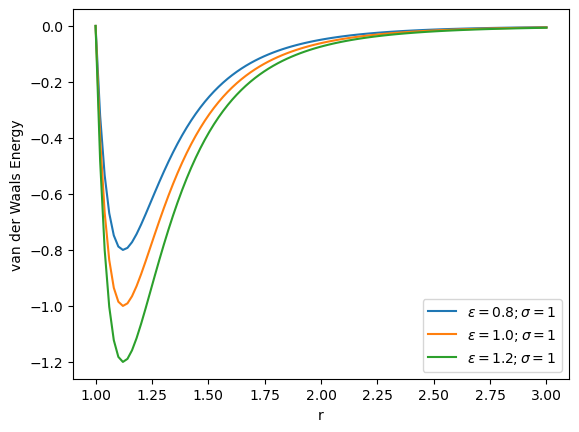

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def lennard_jones(r, epsilon, sigma):
    return 4*epsilon * ((sigma/r)**12 - (sigma/r)**6)

distances = np.linspace(1, 3, 100)
sigma = 1
plt.figure()
for epsilon in [0.8, 1, 1.2]:
    plt.plot(distances, lennard_jones(distances, epsilon, sigma),
             label="$\\epsilon=%.1f; \\sigma=%.0f$" %(epsilon, sigma))

plt.xlabel("r")
plt.ylabel("van der Waals Energy")
plt.legend()
plt.show()

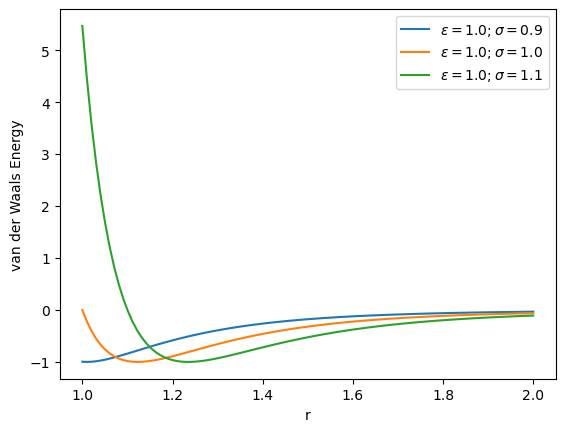

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def lennard_jones(r, epsilon, sigma):
    return 4*epsilon * ((sigma/r)**12 - (sigma/r)**6)

distances = np.linspace(1, 2, 100)
epsilon = 1
plt.figure()
for sigma in [0.9, 1, 1.1]:
    plt.plot(distances, lennard_jones(distances, epsilon, sigma),
             label="$\\epsilon=%.1f; \\sigma=%.1f$" %(epsilon, sigma))

plt.xlabel("r")
plt.ylabel("van der Waals Energy")
plt.legend()
plt.show()

## The Electrostatic Energy
The classical electrostatic energy between two atoms is usually modeled as the Coulomb's law interaction between atom-centered point charges:
\begin{align}
    E_{\rm el}(r_{\rm AB}) = \frac{q_{\rm A} q_{\rm B}}{\epsilon r_{\rm AB}}
\end{align}
where $q_{\rm A}$ and $q_{\rm B}$ are the partial charges of atoms A and B and $\epsilon$ is the dielectric constant. Note that the value of $\epsilon$ is actually a parameter of the model and is not necessarily 1 (for vacuum) or that of the solvent. For example, $\epsilon$ can be set to 1.2 to make 1-4 interactions weaker because they are also accounted for in the torsional terms.

The force fields that depend on permenant and fixed charge  are called *pair-wise*, *additive*, or *nonpolarizable*. These force fields neglect the polarization of one molecule by another (e.g. dipole-induced dipole interactions). Furthermore, these force fields typically use constant values for the charges that do not change as the geometry chages (although the charges themselves can be fitted to multiple conformations of the molecules). The above limitations of pair-wise force fields are addressed by more advanced *polarizable* force fields.

The electrostatic energy is usually the dominant component of the energy for molecular systems. This is because of two reasons: (1) just like for the van der Waals energy, there are ${\sim N^2}$ atom pairs in the system, which is usually much larger than the number of bonded terms; (2) The electrostatic energy is *long-range* and it decays very slowly, unlike the van der Waals energy.

The figure below shows the decay behavior for $r^{-1}, r^{-6}$ and $r^{-12}$.

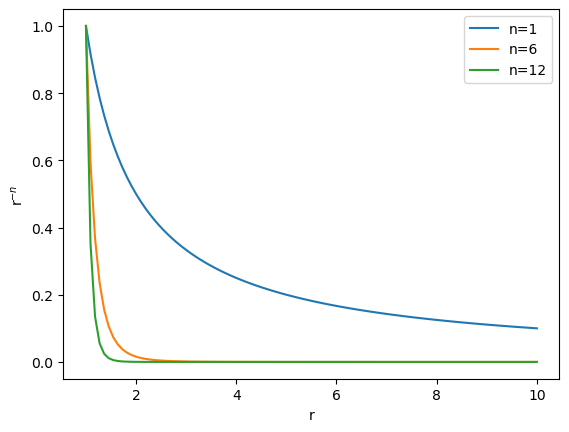

In [7]:
import numpy as np
import matplotlib.pyplot as plt

distances = np.linspace(1, 10, 100)

plt.figure()
plt.plot(distances, 1/distances, label="n=1")
plt.plot(distances, 1/distances**6, label="n=6")
plt.plot(distances, 1/distances**12, label="n=12")

plt.xlabel("r")
plt.ylabel("r$^{-n}$")
plt.legend()
plt.show()

## The Meaning of the Force Field Energy
Quantum mechanical energies have a well-defined reference point, that of infinitely separated electrons and nuclei. What is the reference point for the force field energy? For the valence (or bonded) terms, the reference zero point is a hypothetical system which has all bonds, angles, and torsions at the determined equilibrium values. Thus, any deviation from this hypothetical structure will increase the energy of the system. This energy of the bonded terms is called the *strain energy*. What about the nonbonded terms? For these terms, the reference point is the infinitily separated atoms. These are two incompatible reference points. Thus, *the numerical value of the force field energy has no physical meaning*.

That said, relative values of the force field energy for the same molecule indicates conformational energies. However, the force field energy for two different systems are not directly comparable because they do not have the same zero of energy.

## Example Force Fields
There are a large number of force fields. Generally, force fields are either designed for a specific class of molecules, such as proteins and nucleic acids, or designed to cover general organic or inorganic compounds. The references below include tables that list some of the common force fields. Choosing a given force field for a given problem is not a trivial task. Force fields undergo continuous improvements. 

### Force Fields for Biological Macromolecules
Many force fields are designed for modeling biological macromolecules, such as proteins and nucleic acids. Because they are designed for large systems, they use harmonic potentials. The CHARMM and AMBER force fields, which have many versions, are some of the most popular. General force fields designed to work with CHARMM and AMBER, for example for modeling protein-ligand interactions, are the General CHARMM Force field (CGenFF) and the Generalized AMBER Force Field (GAFF).

### Water Force Fields
Many force fields were developed for modeling water. For some force fields, the water molecule is assumed to be rigid. The TIP3P and the SPC models put partial charges only on the three atoms, while the TIP5P model put additional charges on the lone pairs.

#### Example: Force field parameters for the TIP3P water model
For the bonded TIP3P terms, we have only one bond stretching term and one angle bending term, each requiring two parameters. We also have two van der Waals terms for the hydrogen and the oxygen atoms, each requiring two parameters. We also need to specify the partial charges for oxygen and hydrogen. The following table lists all the required parameters:

|Parameter              | Value                      |
|-----------------------|----------------------------|
|$k_{\rm OH}$           |462750.4 kJ/mol⋅nm$^2$      |
|$r_{\rm OH, eq}$       |0.09572 nm                  |
|$k_{\rm HOH}$          |836.8 kJ/mol⋅rad$^2$        |
|$\theta_{\rm HOH, eq}$ |1.82421813418 rad           |
|$q_{\rm O}$            |-0.834e                     |
|$q_{\rm H}$            |0.417e                      |
|$\sigma_{\rm O}$       |0.31507524065751241 nm      |
|$\sigma_{\rm H}$       |1 nm                        |
|$\epsilon_{\rm O}$     |0.635968 kJ/mol             |
|$\epsilon_{\rm H}$     |0 kJ/mol                    |

## How Can We Use Molecular Mechanics Methods?
Given the functional form of the energy of the system, we can calculate the potential energy surface of the molecule (i.e., how the energy of the system changes as a function of the coordinates). For a general system, the number of degrees of freedom is equal to $3N-6$ ($x,y,z$ coordinates for each atom minus 3 translational and 3 rotational degrees of freedom). Scanning the potential energy surface can be done manually if the system is simple or has few important degrees of freedom. For more complex systems, one is often interested in finding the minimum energy structure(s). This can be done by geometry optimization/energy minimization.

### Example: Calculating Conformational Energies

We will illustrate the calculation of the relative conformational energy of 1,2-dichloroethane. We will perform rigid dihedral scans using a force field implemented in the Open Babel package.

In [8]:
# Let's first visualize the molecule
import nglview as nv
from openbabel import openbabel as ob
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt

conv = ob.OBConversion()
mol = ob.OBMol()
conv.ReadFile(mol, "dichloro_ethane.xyz")

view = nv.show_openbabel(mol)
view

NGLWidget()

In [9]:
angles = range(0, 361, 10) # Scan the energy in 10 degrees steps
views = [nv.NGLWidget() for i in range(len(angles))]
dihedral_atoms = [3, 2, 1, 6] # Cl-C-C-Cl torsion
atoms = [mol.GetAtom(atom) for atom in dihedral_atoms]

ff = ob.OBForceField.FindForceField("MMFF94")
energies = []

for i in range(len(angles)):
    # Change the angle and calculate the energy
    mol.SetTorsion(atoms[0], atoms[1], atoms[2], atoms[3], angles[i]*np.pi/180.0)
    ff.Setup(mol)
    energies.append(ff.Energy())
    views[i].add_structure(nv.OpenbabelStructure(mol))

# Obtain the relative energy
energies = np.array(energies)
energies -= np.min(energies)

def show(frame):
    plt.figure()
    plt.plot(angles, energies)
    plt.xlabel("Dihedral Angle ($\\circ$)")
    plt.ylabel("Energy")
    plt.vlines(angles[frame], np.min(energies), np.max(energies), color="k", ls='--')
    plt.show()
    views[frame].center()
    display(views[frame])

widgets.interact(show, frame=widgets.IntSlider(min=0, max=len(angles)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='frame', max=36), Output()), _dom_classes=('widget-intera…

<function __main__.show(frame)>

For complex systems, geometry optimization can be performed to find the minimum energy structure. However, as you can see the in the above plot, there are usually more than one minium except for trivial systems. Optimization methods find the minimum that is closet to the initial structure, which may or may not be the global minimum. We will illustrate this using the dicholoro ethane example. We will start with an initial geometry that has a $10^\circ$ dihedral angle. As shown in the above figure, the closest minimum is at a dihedral angle of $70^\circ$. So this will be the geometry found after energy minimization. For the optimization, we will use a technique called "steepest descent".

In [10]:
mol.SetTorsion(atoms[0], atoms[1], atoms[2], atoms[3], 10.0*np.pi/180.0)
ff.Setup(mol)
views = [nv.NGLWidget(), nv.NGLWidget()]
views[0].add_structure(nv.OpenbabelStructure(mol))

b = ff.SteepestDescent(1000)
ff.GetCoordinates(mol)

print("The dihedral angle is %.1f" %(mol.GetTorsion(atoms[0], atoms[1], atoms[2], atoms[3])))
views[1].add_structure(nv.OpenbabelStructure(mol))
views[1]

The dihedral angle is 69.4


NGLWidget()

If we start from a different initial structure, we can potentially arrive at a lower minimum. For example, if we start from an initial structure that has $140^\circ$ dihedral angle, geometry optimization will lead to the global minimum energy structure, for which the dihedral angle is $180^\circ$.

In [11]:
mol.SetTorsion(atoms[0], atoms[1], atoms[2], atoms[3], 140.0*np.pi/180.0)
ff.Setup(mol)
views = [nv.NGLWidget(), nv.NGLWidget()]
views[0].add_structure(nv.OpenbabelStructure(mol))

b = ff.SteepestDescent(1000)
ff.GetCoordinates(mol)

print("The dihedral angle is %.1f" %(mol.GetTorsion(atoms[0], atoms[1], atoms[2], atoms[3])))
views[1].add_structure(nv.OpenbabelStructure(mol))
views[1]

The dihedral angle is 179.9


NGLWidget()

## The Need for Sampling: Molecular Dynamics Simulations
Finding a minimum energy structure is not enough. Recall that the average of thermodynamic properties can be calculated from the Boltzmann distribution as:
\begin{align}
    \langle x \rangle = \frac{\sum_i x_i e^{-\varepsilon_i/kT}}{\sum_i e^{-\varepsilon_i/kT}}
\end{align}
Thus, a sum over all states (low or high in energy) is needed to calculate any average property. That said, high energy configurations contribute very little to the average (unless there is a very large number of them) because the expoential decays rapidly with the increase in energy. For a rigid system with a deep minimum, the minimum energy structure can provide a reasonable description. However, for flexible systems with a shallow potential energy surface, numerous low-lying minima might exist. Sampling techniques, such as molecular dynamics simulations, enable the exploration of the free energy of the system under realistic conditions (e.g., temperature, pressure, solvent, etc.).

## Useful Resources

- Cramer, C. J. *Essentials of Computational Chemistry: Theories and Models*, 2nd ed.; John Wiley & Sons: Chichester, England, 2004. (Chapters 2 and 13)
- Jensen, F. *Introduction to Computational Chemistry*, 3rd ed.; John Wiley & Sons: Nashville, TN, 2017. (Chapter 2)